## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. It is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

<br>**Name:** Doğukan</br>
<br>**Surname:** Aytekin </br>
<br>**Student ID:** 2200356003</br>

### 1. Introduction
* **Brief overview of the task**
<p>The main task is to build a Naive Bayes classifier for text classification, specifically for distinguishing between spam and ham emails. This involves understanding the Naive Bayes algorithm, preprocessing the data, implementing the classifier, and analyzing its performance.
</p>

* **What are the main components of a Naive Bayes classifier?**
<p>The main components include the prior probabilities of each class, the likelihood of each feature given a class, and the evidence which normalizes the probabilities.
</p>
* **Why do we use Naive Bayes in text classification tasks?**
<p>Naive Bayes is used because it is simple, computationally efficient, and often performs well for text classification due to the conditional independence assumption which, although naive, works well in practice.
</p>
* **What is the significance of Laplace smoothing in Naive Bayes?**
<p>Laplace smoothing is used to handle the problem of zero probabilities in the likelihood estimates, ensuring that no probability is ever zero and improving the robustness of the classifier.
</p>
* **Description of the dataset used for text classification**
<p>The dataset contains emails labeled as either spam or ham. Each email's text content is used as the feature for classification, and the labels indicate whether the email is spam (1) or ham (0).
</p>

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sns.set(style="whitegrid")

In [2]:
# Custom WordCounter
class WordCounter:
    def __init__(self, ngram_range=(1, 1), stop_words=None):
        self.word_counts = defaultdict(int)
        self.total_count = 0
        self.ngram_range = ngram_range
        self.stop_words = stop_words or []
        self.vocabulary_ = []

    def _get_ngrams(self, words):
        ngrams = []
        for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
            ngrams += zip(*[words[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def fit(self, documents):
        for document in documents:
            words = [word for word in document.split() if word not in self.stop_words]
            ngrams = self._get_ngrams(words)
            for ngram in ngrams:
                self.word_counts[ngram] += 1
                self.total_count += 1
        self.vocabulary_ = list(self.word_counts.keys())

    def transform(self, documents):
        word_freqs = []
        for document in documents:
            word_freq = defaultdict(int)
            words = [word for word in document.split() if word not in self.stop_words]
            ngrams = self._get_ngrams(words)
            for ngram in ngrams:
                word_freq[ngram] += 1
            word_freqs.append(word_freq)
        return word_freqs

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

    def get_feature_names_out(self):
        return self.vocabulary_

In [3]:
# Custom TFIDF Transformer
class TFIDF:
    def __init__(self, word_counter):
        self.word_counter = word_counter
        self.idf = {}
        self.num_documents = 0

    def fit(self, documents):
        self.num_documents = len(documents)
        doc_freq = defaultdict(int)
        for document in documents:
            unique_words = set(document.split())
            for word in unique_words:
                doc_freq[word] += 1
        for word, count in doc_freq.items():
            self.idf[word] = np.log(self.num_documents / (1 + count))

    def transform(self, documents):
        tfidf_vectors = []
        for document in documents:
            words = document.split()
            tfidf_vector = defaultdict(float)
            word_freq = defaultdict(int)
            for word in words:
                word_freq[word] += 1
            for word, freq in word_freq.items():
                tf = freq / len(words)
                tfidf_vector[word] = tf * self.idf.get(word, 0)
            tfidf_vectors.append(tfidf_vector)
        return tfidf_vectors

    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

In [4]:
# Custom Naive Bayes Classifier
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.word_probs = {}

    def fit(self, X, y):
        num_documents = len(X)
        self.class_priors = {cls: np.log(sum(y == cls) / num_documents) for cls in np.unique(y)}
        word_counts = {cls: defaultdict(lambda: 0) for cls in np.unique(y)}
        class_word_counts = {cls: 0 for cls in np.unique(y)}

        for xi, label in zip(X, y):
            for word, count in xi.items():
                word_counts[label][word] += count
                class_word_counts[label] += count

        self.word_probs = {
            cls: {
                word: np.log((count + 1) / (class_word_counts[cls] + len(word_counts[cls])))
                for word, count in word_counts[cls].items()
            }
            for cls in np.unique(y)
        }

    def predict_proba(self, X):
        predictions_proba = []
        for xi in X:
            class_scores = {cls: self.class_priors[cls] for cls in self.class_priors}
            for word, count in xi.items():
                for cls in class_scores:
                    class_scores[cls] += self.word_probs[cls].get(word, np.log(1 / (1 + len(self.word_probs[cls])))) * count
            predictions_proba.append(class_scores)
        return predictions_proba

    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        predictions = [max(class_scores, key=class_scores.get) for class_scores in predictions_proba]
        return predictions

In [5]:
# Custom train_test_split
def train_test_split_custom(df, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(df.index)
    test_size = int(len(df) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return df.loc[train_indices], df.loc[test_indices]

In [6]:
# Evaluation Metrics
def evaluate_predictions(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return conf_matrix, accuracy, precision, recall, f1

In [7]:
# Function to process text by removing stopwords and punctuation
def process_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

### 2. Importing Necessary Libraries and Reading the Data

In [8]:
# Read csv data
df = pd.read_csv('emails.csv', encoding='latin-1')

# Apply the text processing function to the entire dataset
df['text'] = df['text'].apply(process_text)

df.head()

,text,spam
0,subject naturally irresistible corporate ident...,1
1,subject stock trading gunslinger fanny merrill...,1
2,subject unbelievable new homes easy im wanting...,1
3,subject color printing special request additio...,1
4,subject money software cds software compatibil...,1


### 3. Data Understanding and Preperation

* Examine the E-Mail Spam Dataset to understand its structure and contents.
* Using the histograms show the distribution of dataset into the spam and ham
emails. (or you can use pie chart)
* Assess the feasibility of current dataset to predict spam or ham based on the
words present in the email text.
* To do so, calculate the frequencies of the words in spam and ham emails. You
can create a frequency dictionary to effectively examine the words and use
them later for Naive Bayes classification.
* Based on the word frequencies, consider leaving out some unique words that
appear less frequently than a specific frequency or appear more frequently than
a specific frequency since they might not be useful. To decide the threshold,
you might need to plot the word frequencies and see in which range of the
frequencies most words are found. Explain why some words might not be
useful for prediction and show your reasoning.
* Provide three examples of keywords that may be indicative of spam or ham,
along with their respective frequencies in spam and ham emails. To decide
this you can use a scatter plot to visualize the word frequencies in logarithmic
scale. You can also choose another visualization process that might help you
to decide. Explain and show your reasoning.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
None


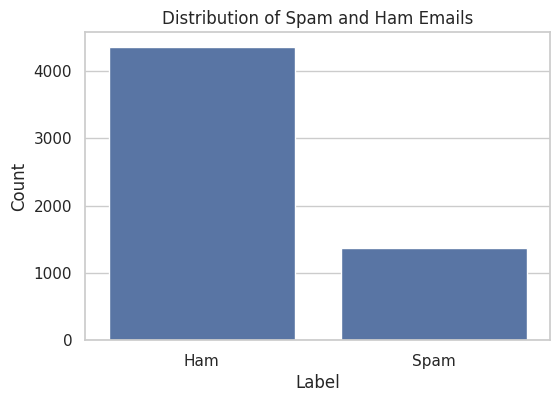

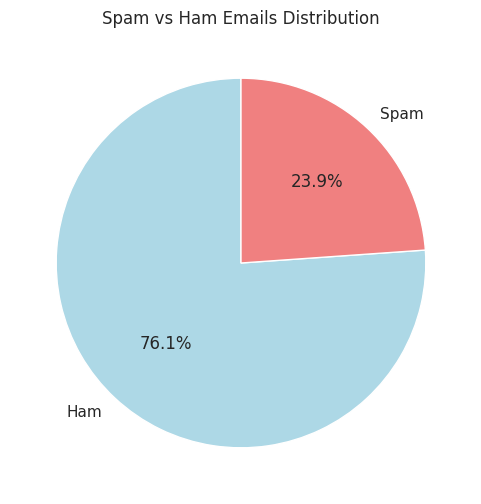

In [9]:
# Display the structure of the dataset
print(df.info())

# Show the distribution of spam and ham emails
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='spam')
plt.title('Distribution of Spam and Ham Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

# Show the distribution using a pie chart
plt.figure(figsize=(6, 6))
df['spam'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'], labels=['Ham', 'Spam'])
plt.title('Spam vs Ham Emails Distribution')
plt.ylabel('')
plt.show()


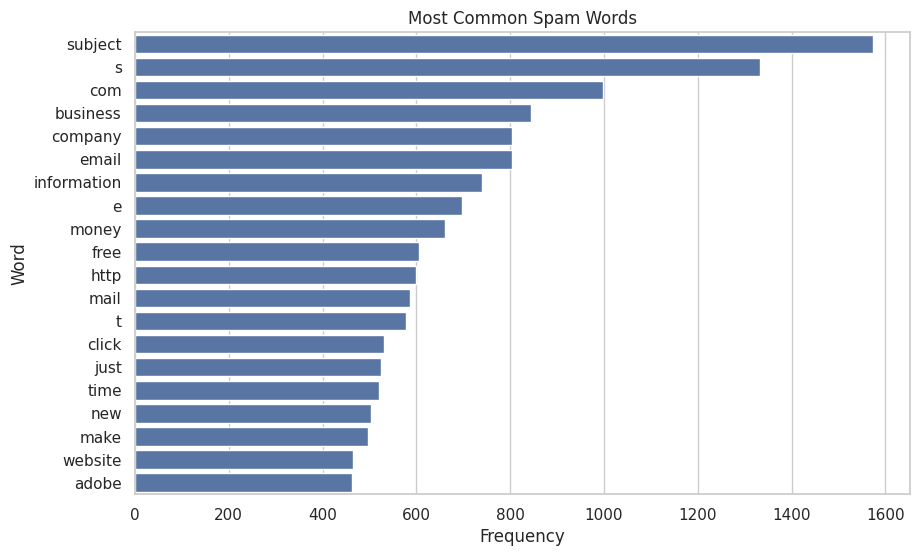

In [10]:
# Calculate word frequencies
vectorizer = WordCounter()
X = vectorizer.fit_transform(df['text'])

# Get the feature names (unique words)
words = list(vectorizer.word_counts.keys())

# Calculate word frequencies in spam and ham emails separately
spam_documents = df[df['spam'] == 1]['text']
ham_documents = df[df['spam'] == 0]['text']

spam_words = vectorizer.transform(spam_documents)
ham_words = vectorizer.transform(ham_documents)

# Sum the frequencies for spam and ham documents
spam_word_counts = defaultdict(int)
ham_word_counts = defaultdict(int)

for doc in spam_words:
    for word, count in doc.items():
        spam_word_counts[word] += count

for doc in ham_words:
    for word, count in doc.items():
        ham_word_counts[word] += count

# Create a DataFrame for word frequencies
word_freq_df = pd.DataFrame({
    'word': words,
    'spam': [spam_word_counts[word] for word in words],
    'ham': [ham_word_counts[word] for word in words]
})

# Visualize the most common spam words
top_words = word_freq_df.sort_values(by='spam', ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='spam', data=top_words)
plt.title('Most Common Spam Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

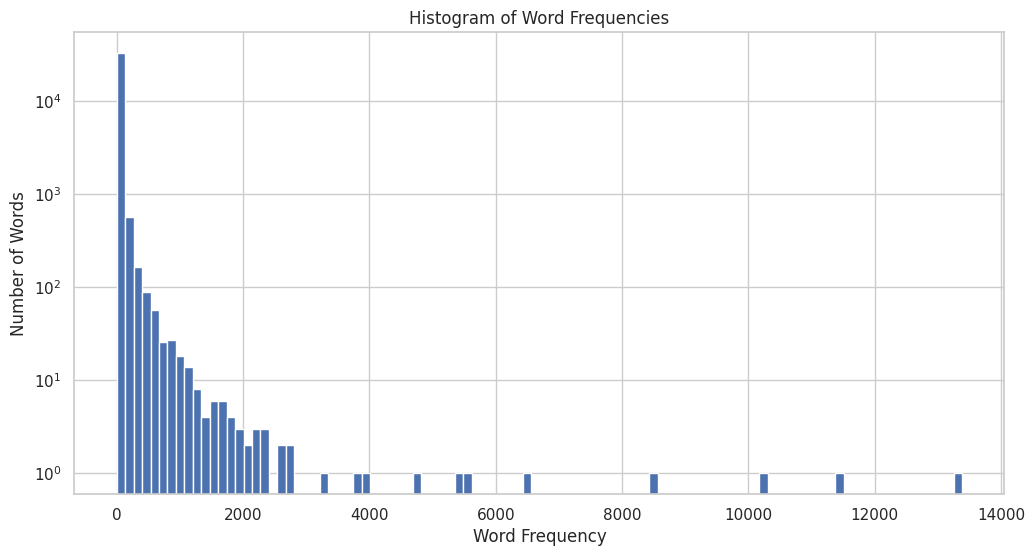

Number of words before filtering: 33445
Number of words after filtering: 11073


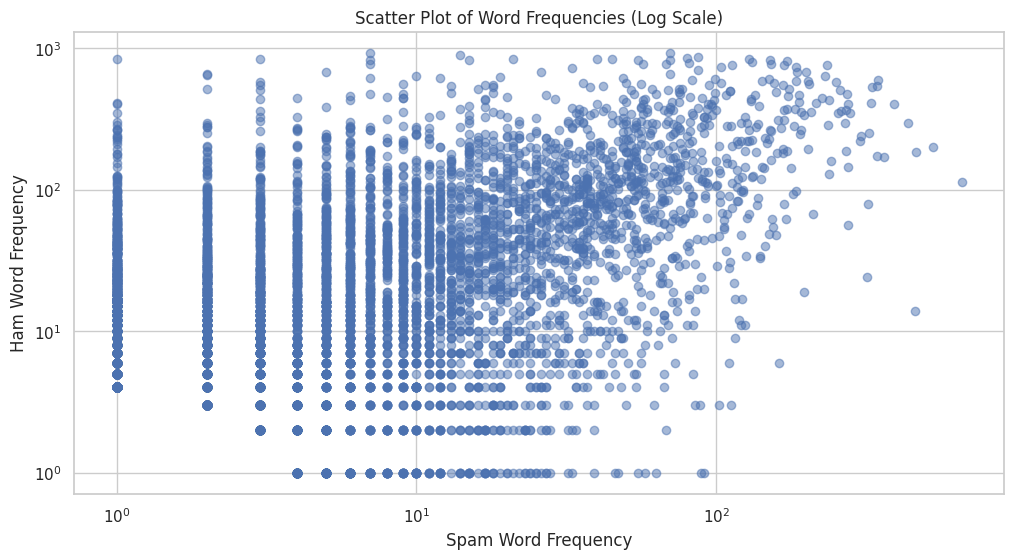

In [11]:
# Plot the word frequencies
word_freq_df['total'] = word_freq_df['spam'] + word_freq_df['ham']
plt.figure(figsize=(12, 6))
plt.hist(word_freq_df['total'], bins=100, log=True)
plt.title('Histogram of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show()

# Decide on a threshold for removing words that are too common or too rare
# For this example, let's consider words that appear less than 5 times or more than 1000 times
threshold_min = 5
threshold_max = 1000
filtered_words = word_freq_df[(word_freq_df['total'] >= threshold_min) & (word_freq_df['total'] <= threshold_max)]

print(f"Number of words before filtering: {len(word_freq_df)}")
print(f"Number of words after filtering: {len(filtered_words)}")

# Reasoning: Words that are too common or too rare may not provide useful information for classification.
# Words that are too rare might be noise, and words that are too common might not distinguish between classes.

# Visualize the filtered word frequencies (scatter plot in logarithmic scale)
plt.figure(figsize=(12, 6))
plt.scatter(filtered_words['spam'], filtered_words['ham'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spam Word Frequency')
plt.ylabel('Ham Word Frequency')
plt.title('Scatter Plot of Word Frequencies (Log Scale)')
plt.show()


Keyword: free, Spam Frequency: 606, Ham Frequency: 530
Keyword: win, Spam Frequency: 36, Ham Frequency: 36
Keyword: money, Spam Frequency: 662, Ham Frequency: 113


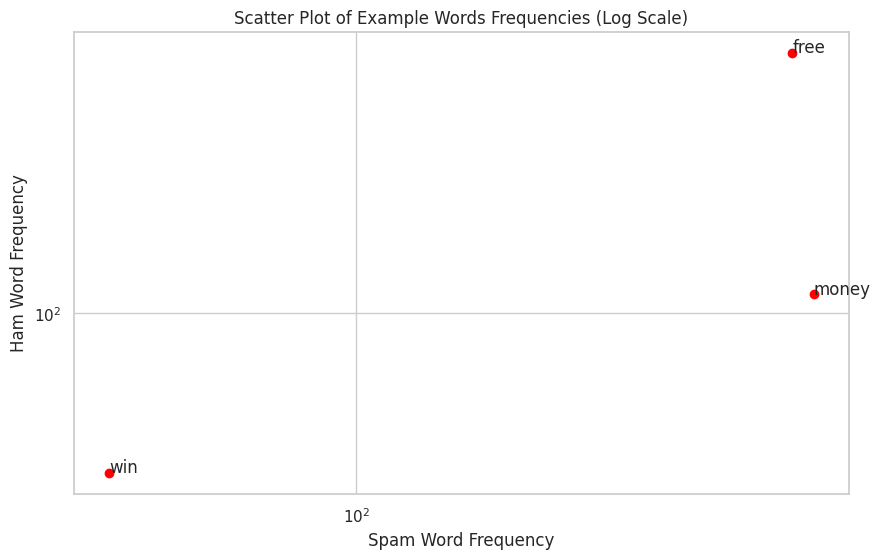

In [12]:
# Example of keywords indicative of spam or ham
keywords = ['free', 'win', 'money']
for keyword in keywords:
    freq_spam = word_freq_df[word_freq_df['word'] == keyword]['spam'].values[0]
    freq_ham = word_freq_df[word_freq_df['word'] == keyword]['ham'].values[0]
    print(f"Keyword: {keyword}, Spam Frequency: {freq_spam}, Ham Frequency: {freq_ham}")

# Visualize these keywords in a scatter plot
example_words = word_freq_df[word_freq_df['word'].isin(keywords)]
plt.figure(figsize=(10, 6))
plt.scatter(example_words['spam'], example_words['ham'], color='red')
for i, word in enumerate(example_words['word']):
    plt.text(example_words['spam'].iloc[i], example_words['ham'].iloc[i], word, fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spam Word Frequency')
plt.ylabel('Ham Word Frequency')
plt.title('Scatter Plot of Example Words Frequencies (Log Scale)')
plt.show()

In [13]:
# Example of keywords indicative of spam or ham
keywords = ['free', 'win', 'money']
for keyword in keywords:
    freq_spam = word_freq_df[word_freq_df['word'] == keyword]['spam'].values[0]
    freq_ham = word_freq_df[word_freq_df['word'] == keyword]['ham'].values[0]
    print(f"Keyword: {keyword}, Spam Frequency: {freq_spam}, Ham Frequency: {freq_ham}")

Keyword: free, Spam Frequency: 606, Ham Frequency: 530
Keyword: win, Spam Frequency: 36, Ham Frequency: 36
Keyword: money, Spam Frequency: 662, Ham Frequency: 113


### 4. Data Representation and Naive Bayes Implementation

* Split your dataset into training and test sets (80-20 split ratio).
* Prepare your training and test data to align with the requirements of your
Naive Bayes implementation. Remember, the training data will provide the
necessary insights to predict whether the test data is spam or ham.
* Represent the data using the Bag of Words (BoW) model with two methods:
Unigram and Bigram. You need to compare the usage of these two methods.
* Create Unigrams and Bigrams then implement your own Naive Bayes classifier,
considering:

  1.   Log probabilities to prevent numerical underflow.
  2.   Dealing with words not encountered during training (possibly using Laplace
  smoothing).
  3. Using a dictionary for BoW representation (either implementing your own
  method or utilizing CountVectorizer from scikit-learn)

#### Splitting the Data

In [14]:
# Split the dataset
df_split = df[['text', 'spam']]
train_df, test_df = train_test_split_custom(df_split, test_size=0.2, random_state=42)
X_train, y_train = train_df['text'], train_df['spam']
X_test, y_test = test_df['text'], test_df['spam']

#### Training and Testing with Unigram

In [15]:
# Bag of Words model with Unigram
vectorizer_unigram = WordCounter()
X_train_unigram = vectorizer_unigram.fit_transform(X_train)
X_test_unigram = vectorizer_unigram.transform(X_test)

# Train Naive Bayes classifier with Unigram
clf_unigram = NaiveBayesClassifier()
clf_unigram.fit(X_train_unigram, y_train)

# Test Naive Bayes classifier with Unigram
y_pred_unigram = clf_unigram.predict(X_test_unigram)

# Performance metrics
conf_matrix_unigram, accuracy_unigram, precision_unigram, recall_unigram, f1_unigram = evaluate_predictions(y_test, y_pred_unigram)

print(f'Unigram Accuracy: {accuracy_unigram}')
print(f'Unigram Precision: {precision_unigram}')
print(f'Unigram Recall: {recall_unigram}')
print(f'Unigram F1 Score: {f1_unigram}')

Unigram Accuracy: 0.9729257641921397
Unigram Precision: 0.9059561128526645
Unigram Recall: 0.996551724137931
Unigram F1 Score: 0.949096880131363


#### Training and Testing with Bigram

In [16]:
# Bag of Words model with Bigram
vectorizer_bigram = WordCounter(ngram_range=(1, 2))
X_train_bigram = vectorizer_bigram.fit_transform(X_train)
X_test_bigram = vectorizer_bigram.transform(X_test)

# Train Naive Bayes classifier with Bigram
clf_bigram = NaiveBayesClassifier()
clf_bigram.fit(X_train_bigram, y_train)

# Test Naive Bayes classifier with Bigram
y_pred_bigram = clf_bigram.predict(X_test_bigram)

# Performance metrics
conf_matrix_bigram, accuracy_bigram, precision_bigram, recall_bigram, f1_bigram = evaluate_predictions(y_test, y_pred_bigram)

print(f'Bigram Accuracy: {accuracy_bigram}')
print(f'Bigram Precision: {precision_bigram}')
print(f'Bigram Recall: {recall_bigram}')
print(f'Bigram F1 Score: {f1_bigram}')

Bigram Accuracy: 0.7921397379912664
Bigram Precision: 0.5492424242424242
Bigram Recall: 1.0
Bigram F1 Score: 0.7090464547677261


### 5. Analyzing Word Influence

* List the 10 words whose presence most strongly predicts that an email is ham.
* List the 10 words whose absence most strongly predicts that an email is ham.
* List the 10 words whose presence most strongly predicts that an email is spam.
* List the 10 words whose absence most strongly predicts that an email is spam.
* Explain how these words were obtained in terms of conditional probabilities
used in the Naive Bayes algorithm.
* Compare the influence of word presence vs absence on predicting spam or ham.

In [ ]:
# Bag of Words model with Unigram
vectorizer_unigram = WordCounter()
X_train_unigram = vectorizer_unigram.fit_transform(X_train)
X_test_unigram = vectorizer_unigram.transform(X_test)

# Train Naive Bayes classifier with Unigram
clf_unigram = NaiveBayesClassifier()
clf_unigram.fit(X_train_unigram, y_train)

# Test Naive Bayes classifier with Unigram
y_pred_unigram = clf_unigram.predict(X_test_unigram)

# Performance metrics
conf_matrix_unigram, accuracy_unigram, precision_unigram, recall_unigram, f1_unigram = evaluate_predictions(y_test, y_pred_unigram)

print(f'Unigram Accuracy: {accuracy_unigram}')
print(f'Unigram Precision: {precision_unigram}')
print(f'Unigram Recall: {recall_unigram}')
print(f'Unigram F1 Score: {f1_unigram}')

# Unigram model word probabilities
feature_names_unigram = vectorizer_unigram.get_feature_names_out()
log_prob_spam_unigram = {word: clf_unigram.word_probs[1].get(word, 0) for word in feature_names_unigram}
log_prob_ham_unigram = {word: clf_unigram.word_probs[0].get(word, 0) for word in feature_names_unigram}

# Top 10 words for ham and spam
top_ham_words = sorted(log_prob_ham_unigram, key=log_prob_ham_unigram.get, reverse=True)[:10]
top_spam_words = sorted(log_prob_spam_unigram, key=log_prob_spam_unigram.get, reverse=True)[:10]

print(f'Top 10 Ham Words: {top_ham_words}')
print(f'Top 10 Spam Words: {top_spam_words}')

Unigram Accuracy: 0.9729257641921397
Unigram Precision: 0.9059561128526645
Unigram Recall: 0.996551724137931
Unigram F1 Score: 0.949096880131363
Top 10 Ham Words: ['secretly', 'cheating', 'screenshots', 'jthomason', 'ebay', 'residents', 'territories', 'virgin', 'guam', 'anatomy']
Top 10 Spam Words: ['insead', 'workshop', 'attending', 'regardoing', 'usefulness', 'enron', 'skilling', 'wharton', 'benjamin', 'parsons']


### 6. Stopword Handling
Analyze the effect of stopwords on the model’s interpretation, discussing reasons for removing or keeping them.

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming

In [ ]:
# Remove stopwords and retrain the model
vectorizer_no_stopwords = WordCounter(stop_words=ENGLISH_STOP_WORDS)
X_train_no_stopwords = vectorizer_no_stopwords.fit_transform(X_train)
X_test_no_stopwords = vectorizer_no_stopwords.transform(X_test)

# Train Naive Bayes classifier without stopwords
clf_no_stopwords = NaiveBayesClassifier()
clf_no_stopwords.fit(X_train_no_stopwords, y_train)

# Test Naive Bayes classifier without stopwords
y_pred_no_stopwords = clf_no_stopwords.predict(X_test_no_stopwords)

# Performance metrics
conf_matrix_no_stopwords, accuracy_no_stopwords, precision_no_stopwords, recall_no_stopwords, f1_no_stopwords = evaluate_predictions(y_test, y_pred_no_stopwords)

print(f'No Stopwords Accuracy: {accuracy_no_stopwords}')
print(f'No Stopwords Precision: {precision_no_stopwords}')
print(f'No Stopwords Recall: {recall_no_stopwords}')
print(f'No Stopwords F1 Score: {f1_no_stopwords}')

No Stopwords Accuracy: 0.9729257641921397
No Stopwords Precision: 0.9059561128526645
No Stopwords Recall: 0.996551724137931
No Stopwords F1 Score: 0.949096880131363


#### Training and Testing with Unigram (Stop Words Removed)

In [ ]:
# Function to process text by removing stopwords
def process_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

# Apply the text processing function to the training and test data
X_train_processed = X_train.apply(process_text)
X_test_processed = X_test.apply(process_text)

# Use WordCounter to convert text data to unigram feature vectors without stopwords
vectorizer_unigram_ns = WordCounter()
X_train_unigram_ns = vectorizer_unigram_ns.fit_transform(X_train_processed)
X_test_unigram_ns = vectorizer_unigram_ns.transform(X_test_processed)

# Train the Naive Bayes classifier on the processed unigram data
clf_unigram_ns = NaiveBayesClassifier()
clf_unigram_ns.fit(X_train_unigram_ns, y_train)

# Test the Naive Bayes classifier on the processed unigram data
y_pred_unigram_ns = clf_unigram_ns.predict(X_test_unigram_ns)

# Calculate performance metrics for the unigram model without stopwords
conf_matrix_unigram_ns, accuracy_unigram_ns, precision_unigram_ns, recall_unigram_ns, f1_unigram_ns = evaluate_predictions(y_test, y_pred_unigram_ns)

# Print the performance metrics
print(f'Unigram (No Stopwords) Accuracy: {accuracy_unigram_ns}')
print(f'Unigram (No Stopwords) Precision: {precision_unigram_ns}')
print(f'Unigram (No Stopwords) Recall: {recall_unigram_ns}')
print(f'Unigram (No Stopwords) F1 Score: {f1_unigram_ns}')

Unigram (No Stopwords) Accuracy: 0.9729257641921397
Unigram (No Stopwords) Precision: 0.9059561128526645
Unigram (No Stopwords) Recall: 0.996551724137931
Unigram (No Stopwords) F1 Score: 0.949096880131363


#### Training and Testing with Bigram (Stop Words Removed)

In [ ]:
# Apply the text processing function to the training and test data
X_train_processed = X_train.apply(process_text)
X_test_processed = X_test.apply(process_text)

# Use WordCounter to convert text data to bigram feature vectors without stopwords
vectorizer_bigram_ns = WordCounter(ngram_range=(1, 2))
X_train_bigram_ns = vectorizer_bigram_ns.fit_transform(X_train_processed)
X_test_bigram_ns = vectorizer_bigram_ns.transform(X_test_processed)

# Train the Naive Bayes classifier on the processed bigram data
clf_bigram_ns = NaiveBayesClassifier()
clf_bigram_ns.fit(X_train_bigram_ns, y_train)

# Test the Naive Bayes classifier on the processed bigram data
y_pred_bigram_ns = clf_bigram_ns.predict(X_test_bigram_ns)

# Calculate performance metrics for the bigram model without stopwords
conf_matrix_bigram_ns, accuracy_bigram_ns, precision_bigram_ns, recall_bigram_ns, f1_bigram_ns = evaluate_predictions(y_test, y_pred_bigram_ns)

# Print the performance metrics
print(f'Bigram (No Stopwords) Accuracy: {accuracy_bigram_ns}')
print(f'Bigram (No Stopwords) Precision: {precision_bigram_ns}')
print(f'Bigram (No Stopwords) Recall: {recall_bigram_ns}')
print(f'Bigram (No Stopwords) F1 Score: {f1_bigram_ns}')

Bigram (No Stopwords) Accuracy: 0.7921397379912664
Bigram (No Stopwords) Precision: 0.5492424242424242
Bigram (No Stopwords) Recall: 1.0
Bigram (No Stopwords) F1 Score: 0.7090464547677261


#### Analyzing the Stopwords

* Identify and handle common stopwords.
* List the 10 non-stopwords that most strongly predict that an email is ham.
* List the 10 non-stopwords that most strongly predict that an email is spam.

In [ ]:
# List the 10 non-stopwords that most strongly predict that an email is ham or spam
non_stop_spam = [word for word in top_spam_words if word not in ENGLISH_STOP_WORDS]
non_stop_ham = [word for word in top_ham_words if word not in ENGLISH_STOP_WORDS]

print(f'Top 10 Non-Stopwords Predicting Spam: {non_stop_spam}')
print(f'Top 10 Non-Stopwords Predicting Ham: {non_stop_ham}')

Top 10 Non-Stopwords Predicting Spam: ['insead', 'workshop', 'attending', 'regardoing', 'usefulness', 'enron', 'skilling', 'wharton', 'benjamin', 'parsons']
Top 10 Non-Stopwords Predicting Ham: ['secretly', 'cheating', 'screenshots', 'jthomason', 'ebay', 'residents', 'territories', 'virgin', 'guam', 'anatomy']
